<a href="https://colab.research.google.com/github/LAKSHMISOWJANYA77/Project1/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import StandardScaler # Import StandardScaler here

# ... (rest of your code) ...
# Load dataset
df = pd.read_csv("/content/online_shoppers_intention_cleaned.csv", encoding='latin-1')
df.drop_duplicates(inplace=True)

# Feature Engineering
df["total_page_view"] = df["Administrative_Duration"] + df["Informational_Duration"] + df["ProductRelated_Duration"]
df["total_page_duration"] = df["Administrative_Duration"] + df["Informational_Duration"] + df["ProductRelated_Duration"]

drop_cols = ["SpecialDay", "OperatingSystems", "Browser", "Region", "TrafficType", "Weekend"]
df.drop(columns=drop_cols, inplace=True)

df["Month"] = df["Month"].map({"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "June": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12})
df["VisitorType"] = df["VisitorType"].replace({"Returning_Visitor": 3, "New_Visitor": 1, "Other": 2})
#df["Revenue"] = df["Revenue"].astype(int)
df = df.dropna(subset=["Revenue"])
df["Revenue"] = df["Revenue"].astype(int)

df["S"] = df["PageValues"] * (1 - df["ExitRates"])
df["L"] = df.apply(lambda x: x["Month"] if x["VisitorType"] == 3 else 1, axis=1)
df["R"] = df["Month"].max() - df["Month"] + 1
df["F"] = df["total_page_view"]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["L", "R", "F", "S", "Revenue"]])
########Unsupervised Deep Embedding for Clustering Analysis" by Junyuan Xie, Ross Girshick, and Ali Farhadi


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

# Define Clustering Layer
class ClusteringLayer(Layer):
    def __init__(self, num_clusters, weights=None, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.num_clusters = num_clusters
        self.initial_weights = weights
        self.clusters = None

    def build(self, input_shape):
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.num_clusters, input_shape[1]),
                                        initializer='glorot_uniform',
                                        trainable=True)
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)

    def call(self, inputs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, 1) - self.clusters), axis=2) / 1.0))
        q = q ** ((1.0 + 1.0) / 2.0)
        q /= K.sum(q, axis=1, keepdims=True)
        return q

# Define KL Divergence Loss
def kl_divergence_loss(y_true, y_pred):
    return K.sum(y_true * K.log(y_true / (y_pred + K.epsilon())), axis=-1)

# Define Autoencoder
def build_autoencoder(input_dim, latent_dim=5):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(500, activation='relu')(input_layer)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(2000, activation='relu')(encoded)
    encoded = Dense(latent_dim, activation='relu', name='latent_space')(encoded)

    decoded = Dense(2000, activation='relu')(encoded)
    decoded = Dense(500, activation='relu')(decoded)
    decoded = Dense(500, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    return autoencoder, encoder

# Train Autoencoder Properly
input_dim = df_scaled.shape[1]
autoencoder, encoder = build_autoencoder(input_dim=input_dim)
autoencoder.compile(optimizer=SGD(0.01, 0.9), loss='mse')

# Add Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=256, shuffle=True, callbacks=[early_stopping], verbose=1)

# Extract latent space representations
encoded_data = encoder.predict(df_scaled)

# Apply K-Means for Initial Clustering
n_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoded_data)

# Initialize Clustering Layer
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)

# Define DEC Model
dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
dec_model.get_layer('clustering').set_weights([kmeans.cluster_centers_])

# Corrected Target Distribution Function
def target_distribution(q):
    weight = (q ** 2) / tf.reduce_sum(q, axis=0, keepdims=True)
    return weight / tf.reduce_sum(weight, axis=1, keepdims=True)

# Compile DEC Model
dec_model.compile(optimizer=SGD(0.01, 0.9), loss=kl_divergence_loss)

# Train DEC with Fine-tuning and Improved Convergence
max_iterations = 5000  # Instead of 20000
update_interval = 50  # Update target distribution more frequently
tolerance = 0.001  # Tolerance for stopping criteria
batch_size = 256
data_size = encoded_data.shape[0]

y_pred_last = np.copy(y_pred)

for iteration in range(max_iterations // update_interval):
    print(f"\nIteration {iteration + 1}/{max_iterations // update_interval}")

    if iteration % update_interval == 0:
        q = dec_model.predict(encoded_data, batch_size=batch_size)
        p = target_distribution(q)

    for batch in range(0, data_size, batch_size):
        batch_end = min(batch + batch_size, data_size)
        dec_model.train_on_batch(encoded_data[batch:batch_end], p[batch:batch_end])

    y_pred_new = q.argmax(axis=1)
    delta = np.sum(y_pred_new != y_pred_last).astype(np.float32) / y_pred_new.shape[0]
    print(f"Cluster assignment change: {delta:.6f}")

    if delta < tolerance:
        print("Converged! Stopping training.")
        break

    y_pred_last = np.copy(y_pred_new)

df["Cluster_DEC"] = y_pred_new
print("Final cluster distribution:", Counter(y_pred_new))

# Compute Silhouette Score
silhouette_dec = silhouette_score(encoded_data, y_pred_new)
print(f"Silhouette Score (DEC): {silhouette_dec:.4f}")

#########



<ipython-input-1-736478b76ac5>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["VisitorType"] = df["VisitorType"].replace({"Returning_Visitor": 3, "New_Visitor": 1, "Other": 2})


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 1.0023
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.7601
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.3066
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.1522
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0839
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0452
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0210
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0102
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0047
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0027
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0015
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0012
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 9.1007e-04
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 7.4055e-04
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - los


====== CRM Results ======
{'Cluster_DEC':                     L         R            F          S   Revenue
Cluster_DEC                                                      
0            8.346627  4.614722   647.639693   0.377383  0.000000
1            3.894837  6.817035  1386.230449   2.144106  0.000000
3            6.234151  4.820041  3378.952117  46.189470  0.935583
4            7.641892  4.092342  2504.093202  11.332680  0.745495}

====== CPA Results ======
             Cluster_DEC
Cluster_DEC             
0                   5692
1                   4203
4                   1332
3                    978


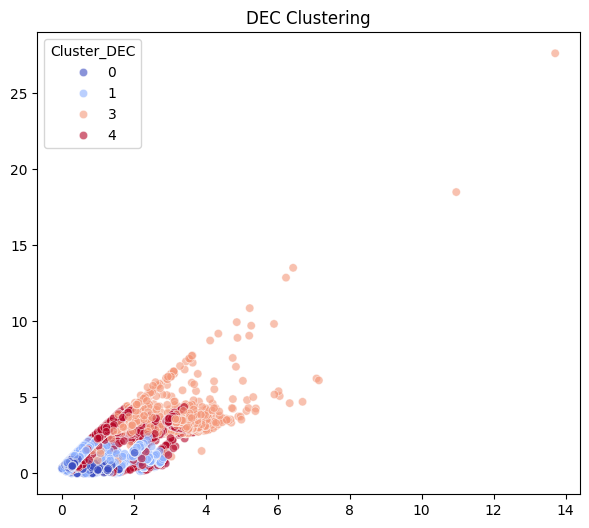

Silhouette Score (DEC): 0.36791661381721497
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

====== Test Case Assignments ======
    L  R   F   S  Revenue  Cluster      Cluster_Label
0   5  7  20   5        0        0  Passive Customers
1   3  2  50  30        1        1   Bargain Basement
2  10  6  10   1        0        2     Carriage Trade


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Compute CRM and CPA for DEC only
crm_results = {"Cluster_DEC": df.groupby("Cluster_DEC")[["L", "R", "F", "S", "Revenue"]].mean()}
cpa_results = pd.DataFrame({"Cluster_DEC": df["Cluster_DEC"].value_counts()})

# Print CRM and CPA results
print("\n====== CRM Results ======")
print(crm_results)
print("\n====== CPA Results ======")
print(cpa_results)

# Scatterplot Visualization for DEC only
plt.figure(figsize=(7, 6))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=df["Cluster_DEC"], palette="coolwarm", alpha=0.6)
plt.title("DEC Clustering")
plt.show()

# Compute Silhouette Score for DEC
silhouette_dec = silhouette_score(encoded_data, df["Cluster_DEC"])  # Use df["Cluster_DEC"] for DEC labels
print(f"Silhouette Score (DEC): {silhouette_dec}")

# Test Case Mapping using DEC cluster assignments
test_cases = pd.DataFrame({"L": [5, 3, 10], "R": [7, 2, 6], "F": [20, 50, 10], "S": [5, 30, 1], "Revenue": [0, 1, 0]})
test_cases_scaled = scaler.transform(test_cases)
test_cases_encoded = encoder.predict(test_cases_scaled)
test_labels = kmeans.predict(test_cases_encoded)
test_cases["Cluster"] = test_labels
test_cases["Cluster_Label"] = test_cases["Cluster"].map({
    0: "Passive Customers",
    1: "Bargain Basement",
    2: "Carriage Trade",
    3: "Aggressive Customers",
    4: "Loyal Buyers",
    5: "Potential Buyers"
})

print("\n====== Test Case Assignments ======")
print(test_cases)


<ipython-input-3-d8e086353239>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster_DEC", data=df, palette="coolwarm")


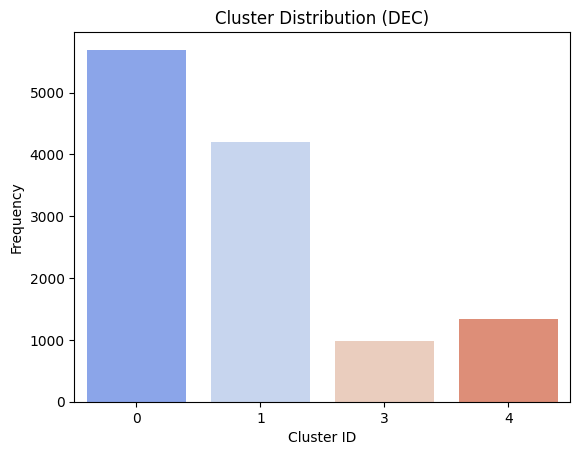

In [ ]:

# Visualize the distribution of clusters
sns.countplot(x="Cluster_DEC", data=df, palette="coolwarm")
plt.title("Cluster Distribution (DEC)")
plt.xlabel("Cluster ID")
plt.ylabel("Frequency")
plt.show()



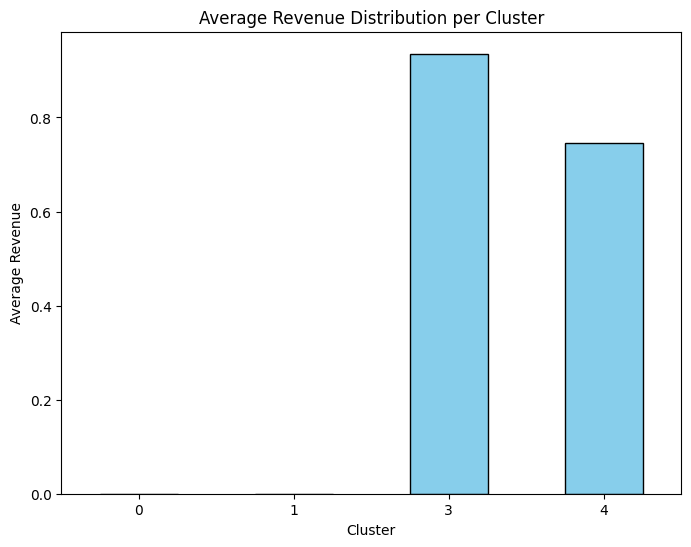

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean Revenue for each cluster
revenue_distribution = df.groupby("Cluster_DEC")["Revenue"].mean()

# Plot the bar chart
plt.figure(figsize=(8, 6))
revenue_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Revenue Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Revenue')
plt.xticks(rotation=0)
plt.show()
